<a href="https://colab.research.google.com/github/TienLungSun/Intelligent-camera-based-motion-analysis/blob/main/1.%20(v2)%20SubjectTracking%26JointDetection%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 可調整參數

In [ ]:
# Used in Track_subjects(frame, prev_boxes, boxes)
# Bbox tracking 可選擇互動模式 (1), 或自動模式 (2, 3)
# 1 Interaction mode: If the two tracking criteria give contradicting results, then ASK THE USER FOR ANSWER
# 2 Use linear_sum_assignment(cost) to match
# 3 Use my simple criteris to match

BBox_tracking_mode = 3

In [ ]:
# used in Redundant_bbox(new_idx, boxes, active_tracklets):
# threshold for two bbox upper left point be treated as the same
redundant_box_pixels = 5 

In [ ]:
# 畫 bbox 的 thickness 與 text 的 size
rect_th=3
text_th=1
text_size=1

# skeleton drawing parameters
circle_r = 2
line_th = 6

In [ ]:
class_index = 1  # 1 = people
score_threshold = 0.8  # threshold to recognize subject, if too restricted, we will keep loosing subjects
score_threshold_to_AddNewSubject = 0.98 #starting from 2nd frame, we will use a stricted threshold to add subject

# 2. 載入 video file

In [ ]:
import cv2
import imageio
import matplotlib.pyplot as plt
from IPython import display

Colab 選擇上傳 video file

In [ ]:
from google.colab import files
uploaded = files.upload()
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

Anaconda 直接寫檔名

In [ ]:
#fname = "協助翻身坐立.mp4" 
fname = "高醫大健身運動.mp4"

In [ ]:
# get video file informaiton
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
vid = imageio.get_reader(fname, 'ffmpeg')
fps = vid.get_meta_data()['fps']
__width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
__height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('No. of frames = ', total_frames, ", w =", __width, ", h =", __height, ", fps=", fps)

No. of frames =  188 , w = 1112 , h = 618 , fps= 10.0


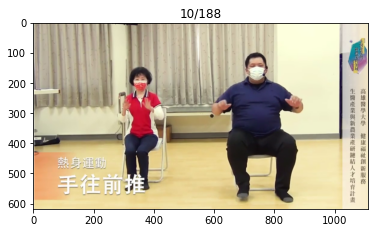

In [ ]:
# take a look at the input video
MaxFrame = 10
frame_count = 1
try:
    while(frame_count <= MaxFrame):
        display.clear_output(wait=True)
        plt.title(str(frame_count)+'/'+str(total_frames))
        frame = vid.get_data(frame_count)  # Capture frame-by-frame
        frame_count += 1
        plt.imshow(frame)
        plt.pause(0.1)
except:
    print("Read video error!")

# 3. Mian program

In [ ]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import pandas as pd
from scipy.optimize import linear_sum_assignment
import os

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device   = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")

NVIDIA GeForce RTX 3060


In [ ]:
#Load keypoints RCNN, which includes Faster RCNN
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval().to(device)

### Functions to draw bbox and skeleton

In [ ]:
# get color for different SID
palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)

In [ ]:
def compute_color_for_labels(label):
    """
    Simple function that adds fixed color depending on the class
    """
    color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)

In [ ]:
# draw skeleton
# 畫線 0 (nose)-3(LEar), 0-4, ...
# For joint indices: https://learnopencv.com/human-pose-estimation-using-keypoint-rcnn-in-pytorch/?ck_subscriber_id=297191382 
PtPairLst = [[0,3], [0, 4], [5, 6], [5, 7], [7, 9], [6, 8], [8, 10], [11, 13], [13, 15], [11, 12], [12, 14], [14, 16]]

In [ ]:
def draw_skeleton(frame, keyPts, color, radius, thickness):
    # keyPts = the 17 key points of this person (x1, y1, visiablity1), ...
    # frame = the image to draw the skeleton
    for i in range(17):
        x = int(keyPts[i][0])
        y = int(keyPts[i][1])
        cv2.circle(frame, (x, y), radius=radius, color=color, thickness=thickness) 

    # 多畫 2 個點: 5 (LShoulder)-6 (RS) 中間,  11(LHip)-12(RH) 中間
    x5_6, y5_6, visiablity1  = (keyPts[5] + keyPts[6])/2
    x11_12, y11_12, visiablity2  = (keyPts[11] + keyPts[12])/2
    x5_6, y5_6, x11_12, y11_12 = int(x5_6), int(y5_6), int(x11_12), int(y11_12)
    cv2.circle(frame, (x5_6, y5_6), radius=radius, color=color, thickness=thickness) 
    cv2.circle(frame, (x11_12, y11_12), radius=radius, color=color, thickness=thickness) 

    # 畫線 LShoulder-RS 5-6, Left Arm: 5-7-9,  RArm 6-8-10
    # LHip-RHip 11-12, Left Leg: 11-13-15, RLeg: 12-14-16
    # Body 0- (5-6中間)-(11-12 中間) 
    for pointPair in PtPairLst:
        ptIdx1, ptIdx2 = pointPair
        x0, y0 = int(keyPts[ptIdx1][0]), int(keyPts[ptIdx1][1])
        x1, y1 = int(keyPts[ptIdx2][0]), int(keyPts[ptIdx2][1])
        cv2.line(frame, (x0, y0), (x1,y1), color=color, thickness=thickness) 
    x0, y0 = int(keyPts[0][0]), int(keyPts[0][1])
    cv2.line(frame, (x0, y0), (x5_6, y5_6), color=color, thickness=thickness)
    cv2.line(frame, (x5_6, y5_6), (x11_12, y11_12), color=color, thickness=thickness)

### Subject tracking functions

In [ ]:
def Recognize_subjects(frame):
    #recognize human subject with bbox score > thresholdin this frame
    #model, class_index, score_threshold are global variables 
    transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(frame).to(device) # Apply the transform to the image
    result = model([img])[0] # Pass the image to the model
    bboxLabels = list(result['labels'].cpu().numpy())
    bboxScore = list(result['scores'].cpu().detach().numpy())
    mask=[]
    for i in range(len(bboxLabels)): #find bbox with score > threshold
        if(bboxLabels[i]==class_index and bboxScore[i]>=score_threshold):
            mask.append(i)
    boxes = result["boxes"][mask].data.cpu().numpy()/np.array([__width, __height, __width, __height])
    bboxScore = list(result['scores'][mask].cpu().detach().numpy())
    skeleton = result['keypoints'][mask].cpu().detach().numpy() #keypoints
    return boxes, bboxScore, skeleton

In [ ]:
def Ask_user_to_match(frame, box1, box2, box3):
    #call from main tracking loop, Ask_user_for_match(prev_boxes[prev_idx], boxes[box_idx], boxes[box_idx2])
    #box1: the bbox in prev. frame, draw in WHITE 
    #box2: the bbox in current frame that matches the prev box by criteria 1 (my criteria)
    #box3: the bbox in current frame that matches the prev box by criteria 2 
    display.clear_output(wait=True)
    colors = [(255, 255, 255), (255, 0, 0), (0, 255, 0)]
    for idx, box in enumerate([box1, box2, box3]):
        x1,y1,x2,y2 = box
        x1,y1,x2,y2 = int(x1*__width), int(y1*__height), int(x2*__width), int(y2*__height)
        cv2.rectangle(frame,(x1, y1), (x2,y2), color=colors[idx], thickness=rect_th*3)
    plt.figure(figsize=(12, 6))
    plt.imshow(frame) 
    plt.show()
    print("Should the WHITE be tracked as RED(1, by linear_sum_assignment) or GREEN(2, by my criteria), or None(3, will be removed)?")
    choice = input("Enter 1~3")
    return int(choice)

In [ ]:
def My_bbox_match(prev_idx, prev_boxes, boxes):
  #my simple rule to match bbox by their corner points
    minValue = 9999
    idx = -99
    x0, y0, x1, y1 = prev_boxes[prev_idx]
    x0, y0, x1, y1  = int(x0*__width), int(y0*__height), int(x1*__width), int(y1*__height)
    for i in range(len(boxes)):
        bbox = boxes[i]
        minX, minY, maxX, maxY = bbox
        minX,minY,maxX,maxY = int(minX*__width), int(minY*__height), int(maxX*__width), int(maxY*__height)
        diff=abs(minX-x0)+abs(minY-y0)+abs(maxX-x1)+abs(maxY-y1)
        if(diff<minValue):
            idx = i
            minValue = diff
    return idx

In [ ]:
def Track_subjects(frame, prev_boxes, boxes):
    #The 2nd method to match the bbox indices in this frame vs prev frame 
    #The 2nd tracking method linear_sum_assignment(cost) is adopted from: https://sparrow.dev/simple-pytorch-object-tracking/
    
    #find matched bboxes in prev frame and current frame
    
    cost=np.linalg.norm(prev_boxes[:, None] - boxes[None], axis=-1)
    prev_indices, boxes_indices = linear_sum_assignment(cost)

    # for each prev idx, find the best match
    matched_prev_indices = []
    matched_indices = []
    removed_prev_idxes = []
    for prev_idx, box_idx in zip(prev_indices, boxes_indices):
        matched_prev_indices.append(prev_idx)
        box_idx2 = My_bbox_match(prev_idx, prev_boxes, boxes)
        if(box_idx == box_idx2):
            matched_indices.append(box_idx)
        else: #2個 match方式結果不一致
            img_clone = frame.copy()
            
            if(BBox_tracking_mode == 1):
                answer = Ask_user_to_match(img_clone, prev_boxes[prev_idx], boxes[box_idx], boxes[box_idx2])
            else:
                answer = BBox_tracking_mode -1  # (BBox_tracking_mode=2 linear_sum_assignment, 3 My simple criteris)

            if(answer == 1):
                matched_indices.append(box_idx)
            elif(answer == 2):
                matched_indices.append(box_idx2)
            else: 
                matched_prev_indices.pop() #do not add this prev_idx 
    return matched_prev_indices, matched_indices

In [ ]:
def Redundant_bbox(new_idx, boxes, active_tracklets):
    #排除跟目前 bbox 重疊的新 bbox
    x1,y1,x2,y2 = boxes[new_idx]
    x1,y1,x2,y2 = int(x1*__width), int(y1*__height), int(x2*__width), int(y2*__height)
    for i in range(len(active_tracklets)):
        xx1,yy1,xx2,yy2 = active_tracklets[i]['boxes'][0]
        xx1,yy1,xx2,yy2 = int(xx1*__width), int(yy1*__height), int(xx2*__width), int(yy2*__height)
        if( (abs(x1-xx1)<redundant_box_pixels or x1>xx1) and  (abs(x2-xx2)<redundant_box_pixels or x2<xx2) and 
            (abs(y1-yy1)<redundant_box_pixels or y1>yy1) and  (abs(y2-yy2)<redundant_box_pixels or y2<yy2) ): 
            print("New box is inside an existed box")
            return True
        elif( (abs(x1-xx1)<redundant_box_pixels or x1<xx1) and  (abs(x2-xx2)<redundant_box_pixels or x2>xx2) and 
              (abs(y1-yy1)<redundant_box_pixels or y1<yy1) and  (abs(y2-yy2)<redundant_box_pixels or y2>yy2) ): 
            print("New box includes an existed box")
            return True
    return False

### Subject tracking 過程中, 每次要新增或移除 Subject ID 時會 save 一張 image, 讓使用者可以比對了解數據檔 subject ID 代表的人是誰

In [ ]:
def save_image (frame_count, frame, boxes, idx, msg):
    # 每次新增或移除 Subject ID 時, 不再詢問使用者,  只是記錄一張 image, 讓使用者可以人工追蹤比對數據檔
    # boxes - the recognized bbox 
    # idx - bbox to be added or removed
    # subjectID - subject ID of this bbox
    # result_dir is global variables
    x1,y1,x2,y2 = boxes[idx]
    x1,y1,x2,y2 = int(x1*__width), int(y1*__height), int(x2*__width), int(y2*__height)
    cv2.rectangle(frame,(x1, y1), (x2,y2), color=(255, 255,255), thickness=rect_th)
    
    #在 img 底部黑底白字顯示 msg
    t_size = cv2.getTextSize(msg, cv2.FONT_HERSHEY_PLAIN, 2 , 2)[0]
    cv2.rectangle(frame,(x1, y1), (x1+t_size[0]+3, y1+t_size[1]+4), (0, 0, 0),-1)
    cv2.putText(frame, msg, (x1, y1+t_size[1]+4), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
   
    fname = "frame_" + str(frame_count)+ ".jpg"
    im = Image.fromarray(frame)
    im.save(os.path.join(result_dir, fname))

In [ ]:
def Draw_tracking_results_to_frame(active_tracklets, frame):
    for i in range(len(active_tracklets)):
        x1,y1,x2,y2 = active_tracklets[i]['boxes'][0]
        x1,y1,x2,y2 = int(x1*__width), int(y1*__height), int(x2*__width), int(y2*__height)
        sid=active_tracklets[i]['sid']
        color=compute_color_for_labels(sid+2)
        t_size = cv2.getTextSize(str(sid), cv2.FONT_HERSHEY_PLAIN, 2 , 2)[0]
        cv2.rectangle(frame,(x1, y1), (x2,y2), color=color, thickness=rect_th)
        cv2.rectangle(frame,(x1, y1), (x1+t_size[0]+3, y1+t_size[1]+4), color,-1)
        cv2.putText(frame,str(sid),(x1,y1+t_size[1]+4), cv2.FONT_HERSHEY_PLAIN, 2, [255,255,255],2) 
        draw_skeleton(frame,active_tracklets[i]['skeleton'][0], color, radius=circle_r, thickness=line_th)
    return frame

In [ ]:
def Update_tracking_data_list(frame_count, active_tracklets):
  #active_tracklets,skeleton,SubjectTrackingResults, JointDetectionResults are global variables
    for i in range(len(active_tracklets)):
        x1,y1,x2,y2 = active_tracklets[i]['boxes'][0]
        x1,y1,x2,y2 = int(x1*__width), int(y1*__height), int(x2*__width), int(y2*__height)
        sid=active_tracklets[i]['sid']
        SubjectTrackingResults.append((frame_count, sid, x1,y1, x2, y2)) 
        JointDetectionResults.append((frame_count,sid, active_tracklets[i]['skeleton'][0])) 
    return frame

# The main subject tracking and joint detection loop

In [ ]:
# Use the name of the input video file to create directory to save results
fnamePrefix = fname.rsplit(".", 1)[0] #get pre-fix part of fname 
result_dir = fnamePrefix + '_Results' 
os.makedirs(result_dir, exist_ok=True)

No. of humans recognized in this frame = 2
No. of subjects tracked =  2 , SID =  [1, 2]
Bboxes in PREV frame:               [0, 1]
Matched bbox indices in THIS frame: [0, 1]


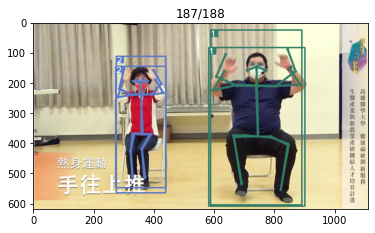

In [ ]:
active_tracklets = []  #目前追蹤中
finished_tracklets = [] #完成追蹤
SubjectTrackingResults = []
JointDetectionResults = []
frame_count = 1
subjectID = 0
videoFname = "Result.mp4"  
Writer = imageio.get_writer(os.path.join(result_dir, videoFname), fps=fps)
logFname = "Log.csv"
logf = open(os.path.join(result_dir, logFname), 'w')
logf.write("Frame, No. of humans recognized in this frame, No. of subjects tracked, SID, Bboxes in prev frame, Matched bbox indices in this frame \n")

while(frame_count < total_frames):
    display.clear_output(wait=True)
    plt.title(str(frame_count)+'/'+str(total_frames))
    frame = vid.get_data(frame_count)  # Capture frame-by-frame
    
    # Recognize humans in the frame
    boxes, bboxScore, skeleton = Recognize_subjects(frame)
    
    if(frame_count == 1): #first frame
        prev_indices = list(range(len(boxes))) #0, 1, 2, ..., len(bbox with score > threshold)
        boxes_indices = [] #mask in current frame
        prev_boxes = boxes
    else:
        print("No. of humans recognized in this frame =", len(boxes))
        print("No. of subjects tracked = ", len(active_tracklets), ", SID = ", [tracklet['sid'] for tracklet in active_tracklets])
        logf.write(str(frame_count)+"," + str(len(boxes)) + ", " + str(len(active_tracklets)) + ",")
        logMsg = " "
        for tracklet in active_tracklets:
            logMsg = logMsg + str(tracklet['sid']) + " "
        logMsg = logMsg + ","
        logf.write(logMsg)

        prev_indices, boxes_indices = Track_subjects(frame, prev_boxes, boxes)
        frame_with_prev_results = Draw_tracking_results_to_frame(active_tracklets, frame) # show prev frame tracking results on current frame
        print("Bboxes in PREV frame:              ", prev_indices)
        print("Matched bbox indices in THIS frame:", boxes_indices)
        logMsg = ' '.join(str(e) for e in prev_indices)+ ", " + ' '.join(str(e) for e in boxes_indices) + "\n"
        logf.write(logMsg)
        
    # Mactch bboxes in current frame with prev frame and update active tracklets
    for prev_idx, idx in zip(prev_indices, boxes_indices):
        active_tracklets[prev_idx]["boxes"] = [np.round(boxes[idx], 3).tolist()]
        active_tracklets[prev_idx]["skeleton"] = [np.round(skeleton[idx], 3)]

    # record lost tracklets
    lost_indices = set(range(len(active_tracklets))) - set(prev_indices)
    for lost_idx in sorted(lost_indices, reverse=True):
        msg = "Frame "+ str(frame_count) + " Remove subject " + str(active_tracklets[lost_idx]["sid"])
        save_image (frame_count, frame, prev_boxes, lost_idx, msg)
        finished_tracklets.append(active_tracklets.pop(lost_idx))

    # Activate new tracklets
    new_indices = set(range(len(boxes))) - set(boxes_indices)
    for new_idx in new_indices:
      #if we found new subjects in current frame
        if(frame_count ==1):
            subjectID +=1
            active_tracklets.append({"sid": subjectID, 
                                     "boxes": [np.round(boxes[new_idx],3).tolist()], 
                                     "skeleton": [np.round(skeleton[new_idx],3)]})
        #if this frame is not the first frame
        #we check whether the bbox is overlapping with existing bbox, if so we do not add
        elif(Redundant_bbox(new_idx, boxes, active_tracklets)==False): 
            if(bboxScore[new_idx]>score_threshold_to_AddNewSubject):
                subjectID +=1
                msg =  "Frame "+ str(frame_count) + " Add new subject " + str(subjectID)
                save_image (frame_count, frame, boxes, new_idx, msg)
                active_tracklets.append({"sid": subjectID, 
                                         "boxes": [np.round(boxes[new_idx],3).tolist()], 
                                         "skeleton": [np.round(skeleton[new_idx],3)]}) #dictionary is passed as a reference
    Update_tracking_data_list(frame_count, active_tracklets)
    frame = Draw_tracking_results_to_frame(active_tracklets, frame)
    Writer.append_data(frame)

    plt.imshow(frame)                     
    plt.pause(0.0001)
 
    # "Predict" next frame for comparison
    prev_boxes = np.array([tracklet["boxes"][-1] for tracklet in active_tracklets])
    prev_skeleton = np.array([tracklet["skeleton"][-1] for tracklet in active_tracklets])
    
    frame_count += 1
Writer.close()
logf.close()

In [ ]:
# 如果沒有等到 loop 結束手動 break loop, 需要執行此行
#Writer.close()
#logf.close()

In [ ]:
# save object tracking data to csv file
save_format = '{frame},{id},{x1},{y1},{x2},{y2},{xc},{yc},{xc1},{yc1}\n'
fname = "SubjectBboxData.csv"
with open(os.path.join(result_dir, fname), 'w') as f:
    f.write("frame,ID,x1,y1,x2,y2,xc,yc,xc1,yc1\n")
    for frame_id, sid, x1, y1, x2, y2 in SubjectTrackingResults:
        xc, yc = (x1+x2)/2, (y1+y2)/2
        yc1 = __height - yc
        line = save_format.format(frame=frame_id, id=sid, x1=x1, y1=y1,x2=x2, y2=y2, xc=xc, yc=yc, xc1=xc, yc1=yc1)
        f.write(line)

In [ ]:
# save joint data to csv file

# header line for joint data csv
columnLst = ["frameNo", "sid"]
for i in range(1, 18):
    xs = "x" + str(i)
    ys = "y" + str(i)
    columnLst = columnLst + [xs, ys]

lst = []
for frame_id, sid, skeletonarray in JointDetectionResults:
    elt = [frame_id, sid]
    for x, y, visiability in skeletonarray:
        elt = elt + [x,y]
    lst.append(elt)
df = pd.DataFrame(lst, columns = columnLst)
fname = "JointData.csv"
df.to_csv(os.path.join(result_dir, fname), index = False)